### Imports

In [2]:
import os
import time
import copy
import atexit
import pickle
import itertools
import numpy as np
from datetime import datetime
#from concurrent.futures import ProcessPoolExecutor as Pool
from multiprocessing import Pool

from LogicalQ.Logical import LogicalCircuit
from LogicalQ.NoiseModel import construct_noise_model, construct_noise_model_from_hardware_model
from LogicalQ.Library.QECCs import steane_code
from LogicalQ.Analysis import circuit_scaling_bar3d

from qiskit import QuantumCircuit
from qiskit_aer.noise import NoiseModel

### Set up circuit factory

In [3]:
from LogicalQ.Benchmarks import randomized_benchmarking, mirror_benchmarking

def circuit_factory(**kwargs): 
    qc = mirror_benchmarking(**kwargs)
    return qc

Test that benchmark generates physical circuits:

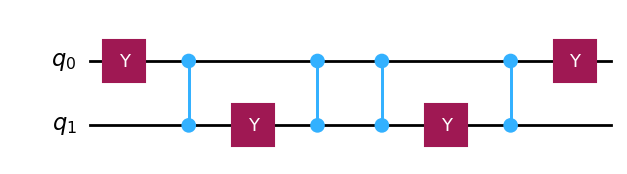

In [4]:
test_qc = circuit_factory(
    n_qubits=2,
    circuit_length=8,
)

test_qc.draw(output='mpl')

In [5]:
print(test_qc.data)

[CircuitInstruction(operation=Instruction(name='y', num_qubits=1, num_clbits=0, params=[]), qubits=(<Qubit register=(2, "q"), index=0>,), clbits=()), CircuitInstruction(operation=Instruction(name='cz', num_qubits=2, num_clbits=0, params=[]), qubits=(<Qubit register=(2, "q"), index=0>, <Qubit register=(2, "q"), index=1>), clbits=()), CircuitInstruction(operation=Instruction(name='y', num_qubits=1, num_clbits=0, params=[]), qubits=(<Qubit register=(2, "q"), index=1>,), clbits=()), CircuitInstruction(operation=Instruction(name='cz', num_qubits=2, num_clbits=0, params=[]), qubits=(<Qubit register=(2, "q"), index=0>, <Qubit register=(2, "q"), index=1>), clbits=()), CircuitInstruction(operation=Instruction(name='cz', num_qubits=2, num_clbits=0, params=[]), qubits=(<Qubit register=(2, "q"), index=0>, <Qubit register=(2, "q"), index=1>), clbits=()), CircuitInstruction(operation=Instruction(name='y', num_qubits=1, num_clbits=0, params=[]), qubits=(<Qubit register=(2, "q"), index=1>,), clbits=()

In [6]:
test_qc.num_qubits

2

In [7]:
lg_test_qc = LogicalCircuit.from_physical_circuit(test_qc, **steane_code)

In [8]:
list(range(lg_test_qc.label[0]))

[0, 1, 2, 3, 4, 5, 6]

In [9]:
list(range(lg_test_qc.label[0], lg_test_qc.num_qubits))

[7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]

### Experiment

In [ ]:
from LogicalQ.Experiments import _basic_experiment_core, execute_circuits
from tqdm import tqdm

def parity_experiment_core(task_id, circuit, noise_model, backend, method, shots, stabilizer_code):
            n_qubits = circuit.n_qubits
            
            if n_qubits <= 2: # Don't go above 2 b/c of RAM requirements
                lg_circuit = LogicalCircuit.from_physical_circuit(circuit, **stabilizer_code)
                lg_circuit.measure_all()
                lg_result = execute_circuits(lg_circuit, noise_model=noise_model, backend=backend, method=method, shots=shots)[0]
                del lg_circuit
            
            circuit.measure_all()
            phys_result = execute_circuits(circuit, noise_model=noise_model, backend=backend, method=method, shots=shots)[0]
            return task_id, phys_result, lg_result

def circuit_combined_scaling_experiment(circuit_input, noise_model_input=None, min_n_qubits=1, max_n_qubits=16, min_circuit_length=1, max_circuit_length=16, backend="aer_simulator", method="statevector", shots=1024, with_mp=True, save_dir=None, save_filename=None, stabilizer_code=None):
    """_summary_

    Args:
        circuit_input (_type_): _description_
        noise_model_input (_type_, optional): _description_. Defaults to None.
        min_n_qubits (int, optional): _description_. Defaults to 1.
        max_n_qubits (int, optional): _description_. Defaults to 16.
        min_circuit_length (int, optional): _description_. Defaults to 1.
        max_circuit_length (int, optional): _description_. Defaults to 16.
        backend (str, optional): _description_. Defaults to "aer_simulator".
        method (str, optional): _description_. Defaults to "statevector".
        shots (int, optional): _description_. Defaults to 1024.
        with_mp (bool, optional): _description_. Defaults to True.
        save_dir (_type_, optional): _description_. Defaults to None.
        save_filename (_type_, optional): _description_. Defaults to None.

    Raises:
        ValueError: _description_
        ValueError: _description_

    Returns:
        _type_: _description_
    """
    
    if isinstance(circuit_input, QuantumCircuit):
        if max_n_qubits != min_n_qubits:
            print("A constant circuit has been provided as the circuit factory, but a non-trivial range of qubit counts has also been provided, so the fixed input will not be scaled in this parameter. If you would like for the number of qubits to be scaled, please provide a callable which takes the number of qubits, n_qubits, as an argument.")
        if max_circuit_length != min_circuit_length:
            print("A constant circuit has been provided as the circuit factory, but a non-trivial range of circuit lengths has also been provided, so the fixed input will not be scaled in this parameter. If you would like for the circuit length to be scaled, please provide a callable which takes the circuit length, circuit_length, as an argument.")

        circuit_factory = lambda n_qubits, circuit_length: circuit_input
    elif callable(circuit_input):
        circuit_factory = circuit_input
    else:
        raise ValueError("Please provide a QuantumCircuit/LogicalCircuit object or a method for constructing QuantumCircuits/LogicalCircuits.")

    if noise_model_input is None:
        # Default option which lets users skip the noise model input, especially if their backend is a hardware backend
        noise_model_factory = lambda n_qubits=None, circuit_length=None : None
    elif isinstance(noise_model_input, NoiseModel):
        if max_n_qubits != min_n_qubits:
            print("A constant noise model has been provided as the noise model factory, but a non-trivial range of qubit counts has also been provided. The number of qubits will not be scaled; if you would like for the number of qubits to be scaled, please provide a callable which takes the number of qubits, n_qubits, as an argument.")

        noise_model_factory = lambda n_qubits: noise_model_input
    elif callable(noise_model_input):
        noise_model_factory = noise_model_input
    else:
        raise ValueError("Please provide a NoiseModel object, a method for constructing NoiseModels, or None (default) if backend is a hardware backend.")

    # Form a dict of dicts with the first layer (n_qubits) initialized to make later access faster and more reliable in parallel
    max_lg_qubits = np.minimum(2, max_n_qubits) 
    phys_all_data = dict(zip(range(min_n_qubits, max_n_qubits+1), [{}]*(max_n_qubits+1-min_n_qubits)))
    lg_all_data = dict(zip(range(min_n_qubits, max_lg_qubits+1), [{}]*(max_lg_qubits+1-min_n_qubits)))

    # Prepare to save progress in the event of program termination
    if save_dir is None:
        save_dir = "./data/"
    if save_filename is None:
        date_str = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        save_filename = f"circuit_scaling_{date_str}.pkl"
        
    phys_save_file = open(save_dir + "phys_" + save_filename, "wb")
    lg_save_file = open(save_dir + "lg_" + save_filename, "wb")
    
    def save_progress():
        pickle.dump(lg_all_data, lg_save_file, protocol=5)
        lg_save_file.close()
        pickle.dump(phys_all_data, phys_save_file, protocol=5)
        phys_save_file.close()
        
    atexit.register(save_progress)

    if with_mp:
        # @TODO Perform rigorous performance test to ensure implementation is fast and robust. There is not enough RAM on my laptop to do multiprocessing, especially since this function bundles in scaling testing for LogicalCircuit objects. Perhaps when PACE access comes online
        
        exp_inputs_list = [
            (
                (n_qubits, circuit_length),
                circuit_factory(n_qubits=n_qubits, circuit_length=circuit_length),
                noise_model_factory(n_qubits=n_qubits),
                backend, method, shots, stabilizer_code
            )
            for (n_qubits, circuit_length) in itertools.product(range(min_n_qubits, max_n_qubits+1), range(min_circuit_length, max_circuit_length+1))
        ]

        cpu_count = (os.cpu_count() - 2) or 1

        # batch_size = max(int(np.ceil((max_n_qubits+1-min_n_qubits)*(max_circuit_length+1-min_circuit_length)/cpu_count)), 1)
        print(f"Applying multiprocessing to {len(exp_inputs_list)} samples across {cpu_count} CPUs")

        start = time.perf_counter()

        with Pool(cpu_count) as pool:
            #results_iterator = pool.imap_unordered(parity_experiment_core), exp_inputs_list)

            #mp_result = list(tqdm(results_iterator, total=len(exp_inputs_list)))
            
            mp_result = pool.starmap(
                parity_experiment_core,
                exp_inputs_list #*[list(exp_inputs) for exp_inputs in zip(*exp_inputs_list)],
                # chunksize=batch_size
            )

            # Unzip results
            for (task_id, phys_result, lg_result) in mp_result:
                phys_all_data[task_id[0]][task_id[1]] = phys_result#[0]
                if task_id[0] <= 2:
                    lg_all_data[task_id[0]][task_id[1]] = lg_result#[0]

        stop = time.perf_counter()
    else:
        start = time.perf_counter()

        prog = 0
        prog_max = (max_n_qubits - min_n_qubits + 1) * (max_circuit_length - min_circuit_length + 1)

        for n_qubits in range(min_n_qubits, max_n_qubits+1):
            phys_sub_data = {}
            lg_sub_data = {}

            noise_model_n = noise_model_factory(n_qubits=n_qubits)

            for circuit_length in range(min_circuit_length, max_circuit_length+1):
                
                prog += 1
                
                # @TODO make this less jank
                print(f"Estimated Progress: {np.round(100 * prog / prog_max, 2)}%")
                
                circuit = circuit_factory(n_qubits=n_qubits, circuit_length=circuit_length)
                
                if n_qubits <= 2: # Don't go above 2 b/c of RAM requirements
                    lg_circuit = LogicalCircuit.from_physical_circuit(circuit, **stabilizer_code)
                    lg_circuit.measure_all()
                    lg_result = execute_circuits(lg_circuit, noise_model=noise_model_n, backend=backend, method=method, shots=shots)[0]
                    lg_sub_data[circuit_length] = lg_result
                    
                    del lg_circuit
                
                circuit.measure_all()
                result = execute_circuits(circuit, noise_model=noise_model_n, backend=backend, method=method, shots=shots)[0]
                phys_sub_data[circuit_length] = result

                del circuit

            del noise_model_n

            phys_all_data[n_qubits] = phys_sub_data
            lg_all_data[n_qubits] = lg_sub_data

        stop = time.perf_counter()

    print(f"Completed experiment in {stop-start} seconds")

    # Run save_progress once for good measure and then unregister save_progress so it doesn't clutter our exit routine
    save_progress()
    atexit.unregister(save_progress)

    return phys_all_data, lg_all_data

### Run experiment

Build noise model:

In [12]:
from qiskit_ibm_runtime.fake_provider import FakeNairobiV2
from qiskit_aer.noise import NoiseModel
from qiskit.visualization import plot_distribution

# Load a fake backend
backend = FakeNairobiV2()
noise_model = NoiseModel.from_backend(backend)

In [ ]:
log_data_serial_phys, log_data_serial_lg = circuit_combined_scaling_experiment(
    circuit_factory,
    noise_model_input=noise_model,
    min_n_qubits=1,
    max_n_qubits=3,
    min_circuit_length=1,
    max_circuit_length=5,
    save_dir="./results/",
    with_mp=True,
    stabilizer_code=steane_code
)

A constant noise model has been provided as the noise model factory, but a non-trivial range of qubit counts has also been provided. The number of qubits will not be scaled; if you would like for the number of qubits to be scaled, please provide a callable which takes the number of qubits, n_qubits, as an argument.
Applying multiprocessing to 15 samples across 30 CPUs


  0%|          | 0/15 [00:00<?, ?it/s]

1 {'0': 963, '1': 61}
1 {'0': 978, '1': 46}
1 {'0': 957, '1': 67}
1 {'0': 962, '1': 62}
1 {'0': 967, '1': 57}
2 {'00': 936, '10': 21, '01': 66, '11': 1}
2 {'00': 944, '01': 60, '10': 18, '11': 2}
2 {'00': 952, '01': 55, '10': 15, '11': 2}
2 {'00': 925, '01': 81, '10': 17, '11': 1}
2 {'00': 942, '10': 26, '01': 54, '11': 2}
3 {'000': 929, '001': 54, '100': 17, '010': 21, '011': 2, '101': 1}
3 {'000': 935, '010': 15, '001': 58, '101': 1, '100': 14, '011': 1}
3 {'000': 924, '010': 20, '001': 53, '100': 21, '011': 3, '101': 2, '110': 1}
3 {'000': 918, '001': 65, '100': 19, '010': 21, '011': 1}
3 {'000': 928, '001': 58, '100': 19, '010': 17, '111': 1, '110': 1}


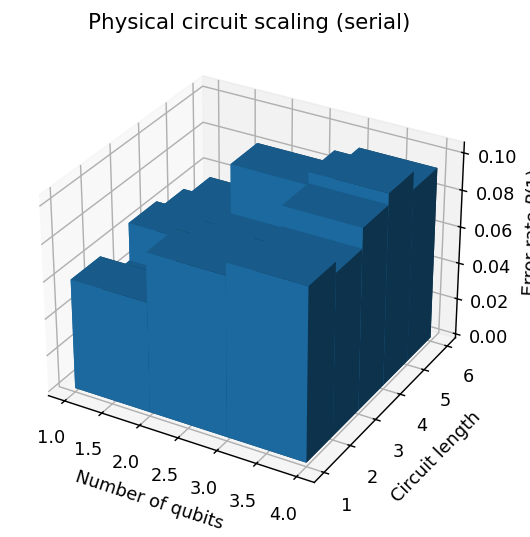

<module 'matplotlib.pyplot' from 'c:\\Users\\nolan\\OneDrive\\Desktop\\College\\Research\\Quantum Computing\\QCA\\clone\\LogicalQ\\venv\\Lib\\site-packages\\matplotlib\\pyplot.py'>

In [ ]:
circuit_scaling_bar3d(log_data_serial_phys, title="Physical circuit scaling (serial)", show=True)

In [ ]:
circuit_scaling_bar3d(log_data_serial_lg, title="Logical circuit scaling (serial)", show=True, circuit_type="logical", qecc=steane_code)

NotImplementedError: LogicalStatevector does not yet support circuits with multiple logical qubits